In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import multipixel_camera_analysis as mca
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [3]:
xtransf_camera_filepath = '/data/beadVideos/bead1109/transfer_funcX/data.h5'
ytransf_camera_filepath = '/data/beadVideos/bead1109/transfer_funcY/data.h5'

xtransf_qpd_filepath = '/data/new_trap/20231109/Bead0/TransFunc/trapFocus/3/TF_X_0.h5'
ytransf_qpd_filepath = '/data/new_trap/20231109/Bead0/TransFunc/trapFocus/3/TF_Y_0.h5'

highP_camera_filepath = '/home/kmkohn/MyCameraEdits/Subsetting_Binning/highP.h5'
gravity_camera_filepath = '/home/kmkohn/MyCameraEdits/Subsetting_Binning/gravdata.h5'

# How to isolate the phase at a given frequency

In [4]:
#Note: use isolate_frequency for 1 frequency in 1 file,
#or h5_fft for all frequencies from 1 file
raw_phase_map = mca.generate_masks(xtransf_camera_filepath,
                                   ytransf_camera_filepath,
                                   271,271,blurred=False)

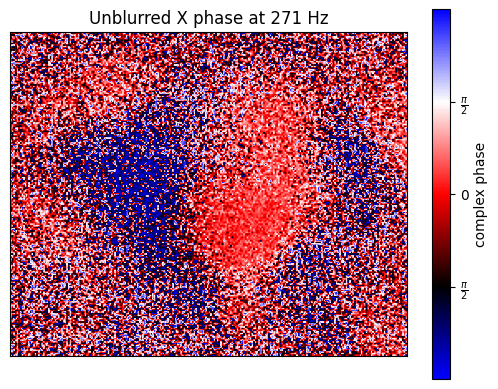

In [5]:
fig, ax = plt.subplots()
mca.make_angleplot(fig, ax, raw_phase_map[...,0], 'Unblurred X phase at 271 Hz')

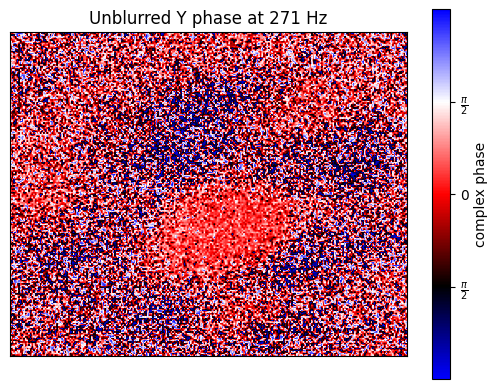

In [6]:
fig, ax = plt.subplots()
mca.make_angleplot(fig, ax, raw_phase_map[...,1], 'Unblurred Y phase at 271 Hz')

In [7]:
binarized_phase_map = mca.generate_masks(xtransf_camera_filepath,
                                   ytransf_camera_filepath,
                                   271,271,blurred=True)

Text(0.5, 1.0, 'Blurred, binarized X phase at 271 Hz')

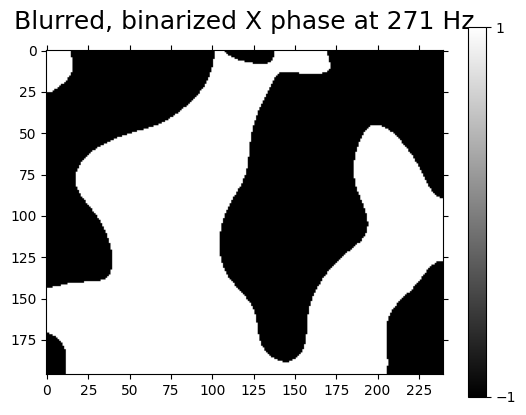

In [8]:
plt.imshow(binarized_phase_map[...,0], cmap='gray')
plt.colorbar(ticks=[-1,1])
plt.title("Blurred, binarized X phase at 271 Hz")

plt.tick_params(top=True, right=True, which='both')
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("Blurred, binarized X phase at 271 Hz", fontsize=18, pad=15)

Text(0.5, 1.0, 'Blurred, binarized Y phase at 271 Hz')

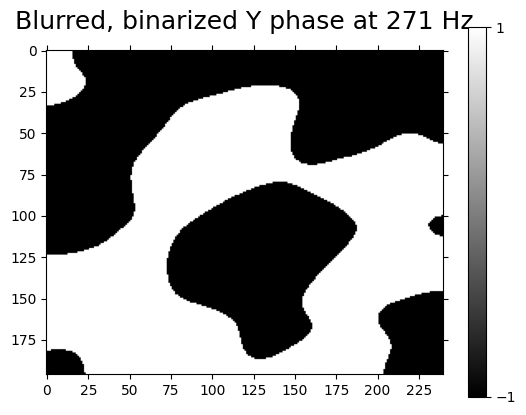

In [9]:
plt.imshow(binarized_phase_map[...,1], cmap='gray')
plt.colorbar(ticks=[-1,1])

plt.tick_params(top=True, right=True, which='both')
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("Blurred, binarized Y phase at 271 Hz", fontsize=18, pad=15)

# How to diagonalize from high pressure data

### Start by getting the resonant frequencies from applying the quadrant map to high pressure data
##### *This is currently done manually. To-do: add a damped harmonic curve fit*

In [10]:
quadmap = mca.generate_quad_masks(mca.getimage0(highP_camera_filepath).shape)
quadsums = mca.parallelSumsMasked_h5(quadmap, highP_camera_filepath, normalize=True)
quadsums = np.array(quadsums)

Starting ForkPoolWorker-1
Starting ForkPoolWorker-2
Starting ForkPoolWorker-3
Starting ForkPoolWorker-4
Starting ForkPoolWorker-5
Starting ForkPoolWorker-6


In [11]:
samplingrate = mca.getsamplingrate(highP_camera_filepath)

#Note: binning just averages each 32 entry sequence, making the plots a bit cleaner
xquad_psd = mca.windowed_psd(quadsums[:,0], samplingrate, samplingrate*10)
xquad_psd_binned = (xquad_psd[0][:-1].reshape(-1, 32).mean(axis=1), xquad_psd[1][:-1].reshape(-1, 32).mean(axis=1))

yquad_psd = mca.windowed_psd(quadsums[:,1], samplingrate, samplingrate*10)
yquad_psd_binned = (yquad_psd[0][:-1].reshape(-1, 32).mean(axis=1), yquad_psd[1][:-1].reshape(-1, 32).mean(axis=1))

Text(0.5, 0, 'Freq [Hz]')

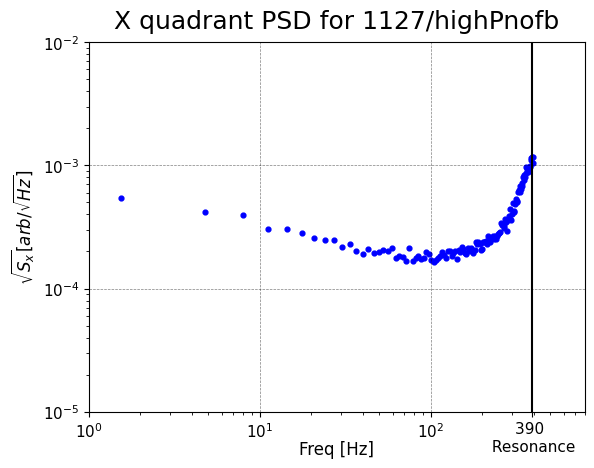

In [12]:
plt.scatter(xquad_psd_binned[1],xquad_psd_binned[0], color="blue", s=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 800)
plt.grid(which='major', linestyle='--', linewidth='0.5', color='black', alpha=0.5)
plt.title("X quadrant PSD for 1127/highPnofb", fontsize=18, pad=10)
plt.axvline(390, color='black')
plt.xticks([1,10,100,390], [r"$10^0$", r"$10^1$", r"$10^2$", '390 \n Resonance'], fontsize=11)
plt.yticks([1e-5,1e-4,1e-3,1e-2], fontsize=11)
plt.ylabel(r'$\sqrt{S_x} [arb/\sqrt{Hz}]$', fontsize=12)
plt.xlabel("Freq [Hz]", fontsize=12,labelpad=-10)

Text(0.5, 0, 'Freq [Hz]')

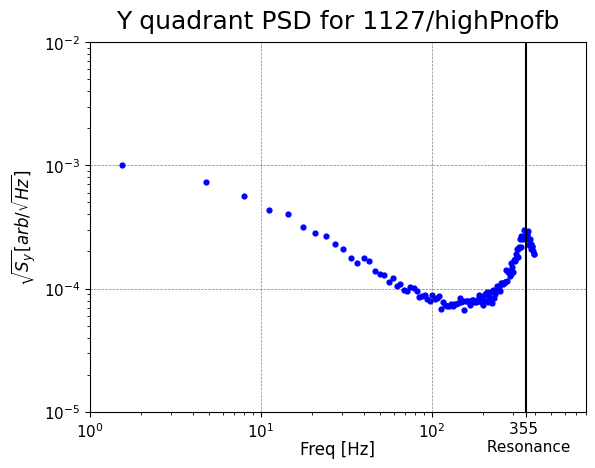

In [13]:
plt.scatter(yquad_psd_binned[1],yquad_psd_binned[0], color='blue',s=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 800)
plt.grid(which='major', linestyle='--', linewidth='0.5', color='black', alpha=0.5)
plt.title("Y quadrant PSD for 1127/highPnofb", fontsize=18, pad=10)
plt.axvline(355, color='black')
plt.xticks([1,10,100,355], [r"$10^0$", r"$10^1$", r"$10^2$", '355 \n Resonance'], fontsize=11)
plt.yticks([1e-5,1e-4,1e-3,1e-2], fontsize=11)
plt.ylabel(r'$\sqrt{S_y} [arb/\sqrt{Hz}]$', fontsize=12)
plt.xlabel("Freq [Hz]", fontsize=12,labelpad=-10)

### Next, create diagonalized maps based on fft data from the resonance frequencies

In [27]:
#Right now, normalization and subsetting are both done by creating a new file. This can likely be improved
#Note: we only need to renormalize manually here so we can take the fft. When we're just summing over an array 
#such as gravity data, this is done automatically frame by frame
target_filepath = 'temp_file.h5'
alltrues = np.full(mca.getimage0(highP_camera_filepath).shape,True)
mca.multisubset(highP_camera_filepath, target_filepath, alltrues)

Starting ForkPoolWorker-13
Starting ForkPoolWorker-14Starting
 ForkPoolWorker-15
Starting ForkPoolWorker-16
Starting ForkPoolWorker-17
Starting ForkPoolWorker-18


In [34]:
diag_masks = mca.generate_diagonal_masks(target_filepath,target_filepath, 390,355)

In [35]:
#This is done because the normalization collapses the image to a single vector, so to apply to
#existing 2 dimensional camera data, it needs to be expanded again
diag_masks_reshaped = np.dstack([mca.expand_fromsubset(diag_masks[...,0],mca.getsubsetmap(target_filepath)),
                               mca.expand_fromsubset(diag_masks[...,1],mca.getsubsetmap(target_filepath))])

In [17]:
os.remove(target_filepath)

Text(0.5, 1.0, 'X map')

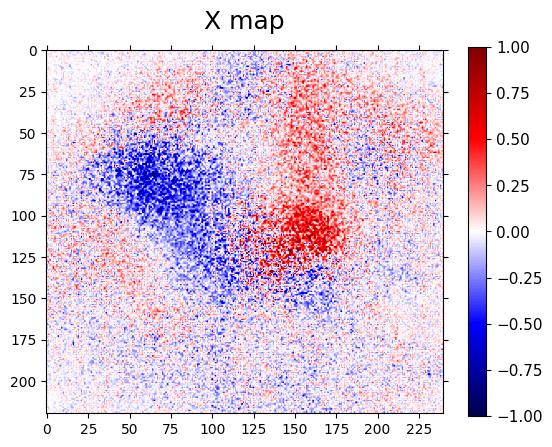

In [36]:
plt.tick_params(top=True, right=True, which='both')

y_diag_map_plot = plt.imshow(diag_masks_reshaped[...,0], cmap='seismic', vmin=-1, vmax=1)
cbar = plt.colorbar(y_diag_map_plot)


cbar.ax.tick_params(labelsize=11)
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("X map", fontsize=18, pad=15)

Text(0.5, 1.0, 'Y map')

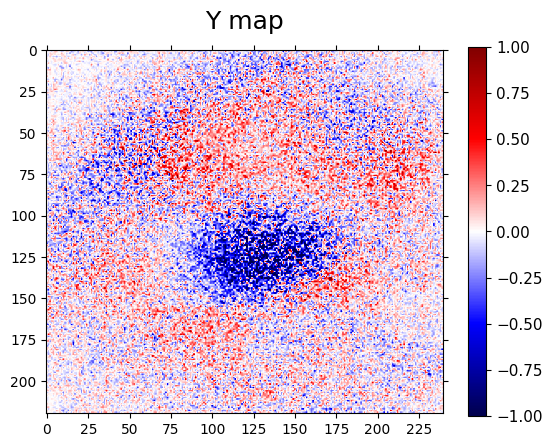

In [38]:
plt.tick_params(top=True, right=True, which='both')

y_diag_map_plot = plt.imshow(diag_masks_reshaped[...,1], cmap='seismic', vmin=-1, vmax=1)
cbar = plt.colorbar(y_diag_map_plot)


cbar.ax.tick_params(labelsize=11)
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("Y map", fontsize=18, pad=15)

In [39]:
#note: this is because high pressure data and gravity data are mismatched. This is normally unnecessary
binarized_phase_map_small = binarized_phase_map[:196]
diag_masks_reshaped_small = diag_masks_reshaped[:196]

# Force normalizing and plotting transfer function curves

In [40]:
phase_force = mca.force_calibration(binarized_phase_map_small, xtransf_camera_filepath, ytransf_camera_filepath,
                                                xtransf_qpd_filepath, ytransf_qpd_filepath, 
                                                  electrons=9, xvals=np.arange(1,100))

diag_force = mca.force_calibration(diag_masks_reshaped_small, xtransf_camera_filepath, ytransf_camera_filepath,
                                                xtransf_qpd_filepath, ytransf_qpd_filepath, 
                                                  electrons=9, xvals=np.arange(1,100))

Starting ForkPoolWorker-19
Starting ForkPoolWorker-20
Starting ForkPoolWorker-21
Starting ForkPoolWorker-22
Starting ForkPoolWorker-23
Starting ForkPoolWorker-24
StartingStartingForkPoolWorker-26  ForkPoolWorker-25

Starting 
ForkPoolWorker-27Starting ForkPoolWorker-28
Starting ForkPoolWorker-29
Starting ForkPoolWorker-30
Starting ForkPoolWorker-31
Starting Starting ForkPoolWorker-32
ForkPoolWorker-33
Starting ForkPoolWorker-34Starting
 ForkPoolWorker-35
Starting ForkPoolWorker-36
Starting ForkPoolWorker-37
Starting ForkPoolWorker-38
Starting ForkPoolWorker-39
Starting ForkPoolWorker-40
Starting ForkPoolWorker-41
Starting ForkPoolWorker-42


Starting ForkPoolWorker-43
Starting ForkPoolWorker-44
Starting ForkPoolWorker-45Starting
 ForkPoolWorker-46
Starting ForkPoolWorker-47
Starting ForkPoolWorker-48
Starting ForkPoolWorker-49
Starting ForkPoolWorker-50
Starting 
ForkPoolWorker-51Starting ForkPoolWorker-52
Starting ForkPoolWorker-53
Starting ForkPoolWorker-54
Starting ForkPoolWorker-55
Starting ForkPoolWorker-56
Starting ForkPoolWorker-57
Starting ForkPoolWorker-58
Starting ForkPoolWorker-59
Starting ForkPoolWorker-60
Starting ForkPoolWorker-61
Starting ForkPoolWorker-62
Starting ForkPoolWorker-63
Starting ForkPoolWorker-64
Starting ForkPoolWorker-65
Starting ForkPoolWorker-66


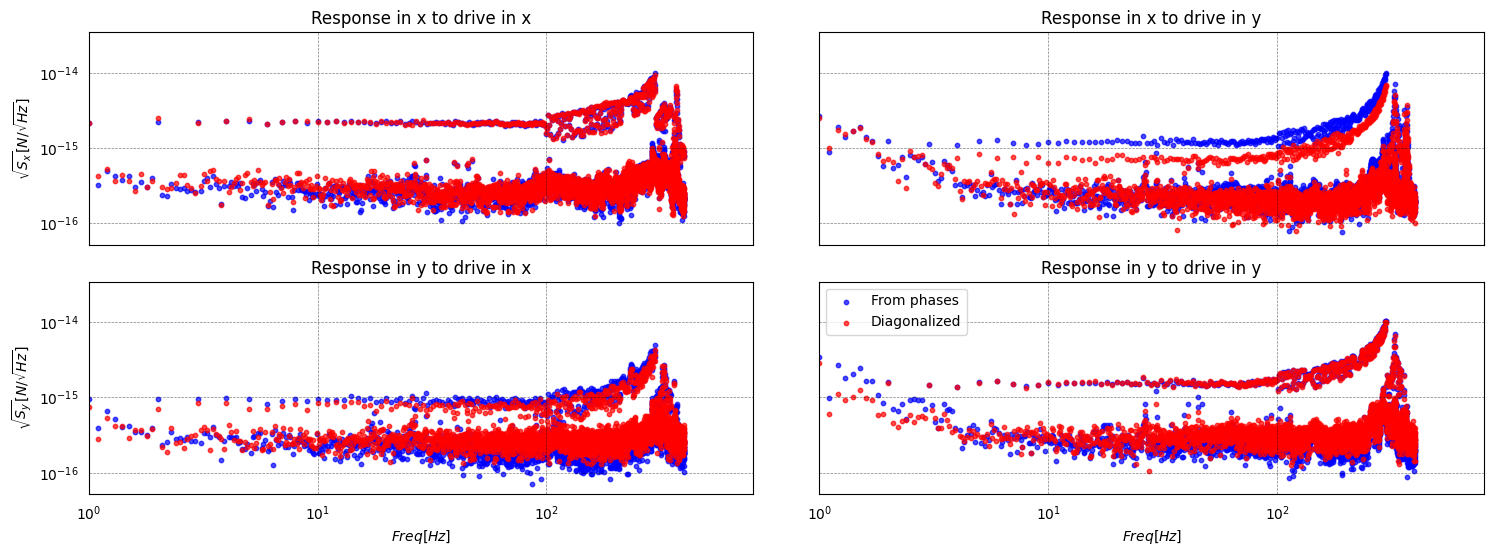

In [41]:
plot_base = mca.makeTransferFuncPlot(binarized_phase_map_small, xtransf_camera_filepath, ytransf_camera_filepath, normscale=phase_force,
                                                color='blue', s=10, marker='o', label='From phases', alpha=0.7)
mca.makeTransferFuncPlot(diag_masks_reshaped_small, xtransf_camera_filepath, ytransf_camera_filepath, normscale=diag_force,
                                                plotbase=plot_base,
                                                color='red', s=10, marker='o', label='Diagonalized', alpha=0.7)
plt.legend()

# Calibrating force and measuring gravity data

In [42]:
sums = mca.parallelSumsMasked_h5(binarized_phase_map_small, gravity_camera_filepath)
resx_phase = mca.windowed_psd(np.array(sums)[:,0]*phase_force[0], mca.getsamplingrate(gravity_camera_filepath))
resy_phase = mca.windowed_psd(np.array(sums)[:,1]*phase_force[1], mca.getsamplingrate(gravity_camera_filepath))
del sums

Starting ForkPoolWorker-67
Starting ForkPoolWorker-68Starting
 ForkPoolWorker-69
Starting ForkPoolWorker-70
Starting ForkPoolWorker-71
Starting ForkPoolWorker-72


In [43]:
sums = mca.parallelSumsMasked_h5(diag_masks_reshaped_small, gravity_camera_filepath)
resx_diag = mca.windowed_psd(np.array(sums)[:,0]*diag_force[0], mca.getsamplingrate(gravity_camera_filepath))
resy_diag = mca.windowed_psd(np.array(sums)[:,1]*diag_force[1], mca.getsamplingrate(gravity_camera_filepath))
del sums

Starting ForkPoolWorker-73
Starting ForkPoolWorker-74
Starting ForkPoolWorker-75
Starting ForkPoolWorker-76
Starting ForkPoolWorker-77Starting
 ForkPoolWorker-78


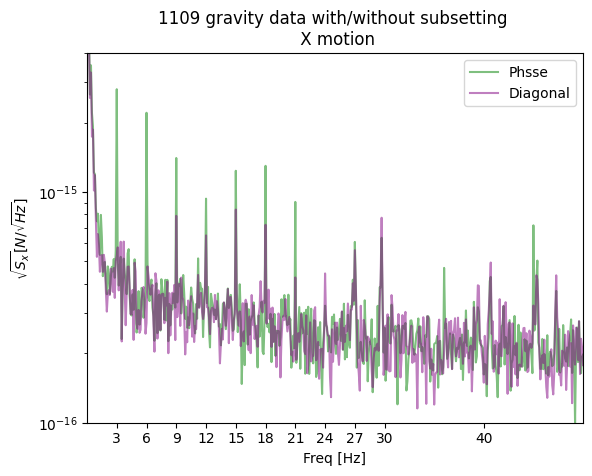

In [44]:
plt.semilogy(resx_phase[1],resx_phase[0], alpha=0.5, label = "Phsse", color='green')
plt.semilogy(resx_diag[1],resx_diag[0], alpha=0.5, label = "Diagonal", color='purple')
plt.xlim([0,50])
plt.ylabel(r'$\sqrt{S_x} [N/\sqrt{Hz}]$')
plt.xlabel("Freq [Hz]")
plt.xticks(np.append(np.arange(3,32,3),40))
plt.title("1109 gravity data with/without subsetting \n X motion")
plt.ylim(1e-16,4e-15)
plt.legend()

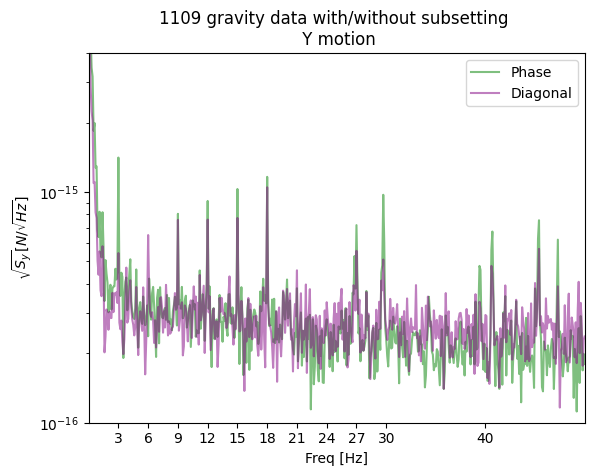

In [45]:
plt.semilogy(resy_phase[1],resy_phase[0], alpha=0.5, label = "Phase", color='green')
plt.semilogy(resy_diag[1],resy_diag[0], alpha=0.5, label = "Diagonal", color='purple')
plt.xlim([0,50])
plt.ylabel(r'$\sqrt{S_y} [N/\sqrt{Hz}]$')
plt.xlabel("Freq [Hz]")
plt.xticks(np.append(np.arange(3,32,3),40))
plt.title("1109 gravity data with/without subsetting \n Y motion")
plt.ylim(1e-16,4e-15)
plt.legend()

# Removing small pixels

0

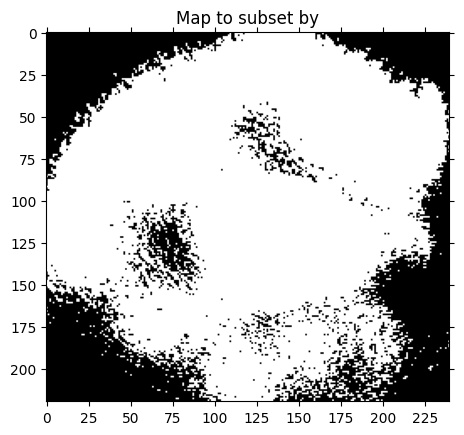

In [46]:
largepixels = mca.getimage0(highP_camera_filepath) > 5
plt.imshow(largepixels, cmap='gray')
plt.title("Map to subset by")
plt.tick_params(top=True, right=True, which='both')
plt.xticks(np.arange(0, plt.xlim()[1], 25))
0

In [47]:
#Right now, normalization and subsetting are both done by creating a new file. This can likely be improved
#Note: we only need to renormalize manually here so we can take the fft. When we're just summing over an array 
#such as gravity data, this is done automatically frame by frame
target_filepath = 'temp_file.h5'
mca.multisubset(highP_camera_filepath, target_filepath, largepixels)

Starting StartingForkPoolWorker-79
 ForkPoolWorker-80Starting
 ForkPoolWorker-81
Starting ForkPoolWorker-82
Starting ForkPoolWorker-83
Starting ForkPoolWorker-84


In [48]:
subset_masks = mca.generate_diagonal_masks(target_filepath,target_filepath, 390,355)

In [49]:
#This is done because the subsetting collapses the image to a single vector, so to apply to
#existing 2 dimensional camera data, it needs to be expanded again
subset_masks_reshaped = np.dstack([mca.expand_fromsubset(subset_masks[...,0],mca.getsubsetmap(target_filepath)),
                               mca.expand_fromsubset(subset_masks[...,1],mca.getsubsetmap(target_filepath))])

In [50]:
os.remove(target_filepath)

Text(0.5, 1.0, 'X map')

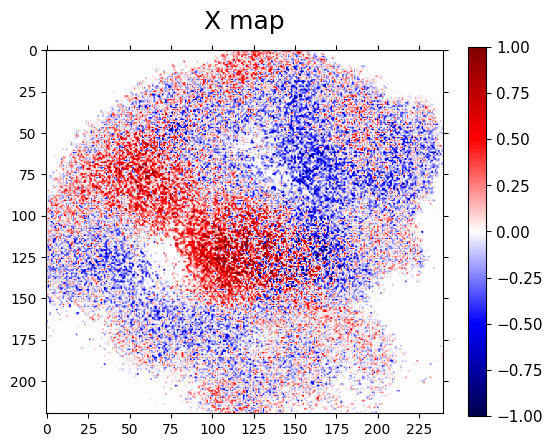

In [51]:
plt.tick_params(top=True, right=True, which='both')

x_subset_map_plot = plt.imshow(subset_masks_reshaped[...,0], cmap='seismic', vmin=-1, vmax=1)
cbar = plt.colorbar(x_subset_map_plot)


cbar.ax.tick_params(labelsize=11)
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("X map", fontsize=18, pad=15)

Text(0.5, 1.0, 'Y map')

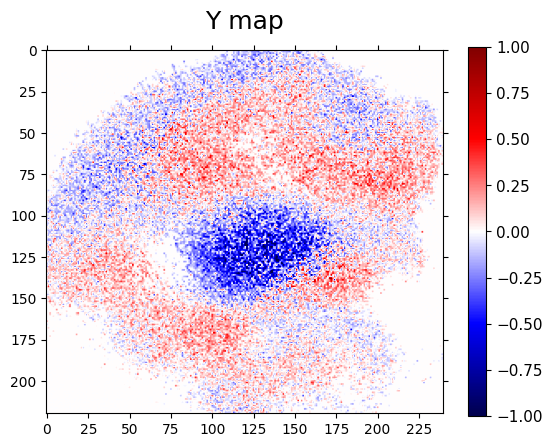

In [52]:
plt.tick_params(top=True, right=True, which='both')

y_subset_map_plot = plt.imshow(subset_masks_reshaped[...,1], cmap='seismic', vmin=-1, vmax=1)
cbar = plt.colorbar(y_subset_map_plot)


cbar.ax.tick_params(labelsize=11)
plt.xticks(np.arange(0, plt.xlim()[1], 25))
plt.title("Y map", fontsize=18, pad=15)

In [54]:
#note: this is because high pressure data and gravity data are mismatched. This is normally unnecessary
subset_masks_reshaped_small = subset_masks_reshaped[:196]

In [55]:
subset_force = mca.force_calibration(subset_masks_reshaped_small, xtransf_camera_filepath, ytransf_camera_filepath,
                                                xtransf_qpd_filepath, ytransf_qpd_filepath, 
                                                  electrons=9, xvals=np.arange(1,100))

Starting ForkPoolWorker-85
Starting ForkPoolWorker-86
Starting ForkPoolWorker-87
Starting ForkPoolWorker-88
 StartingForkPoolWorker-89
Starting ForkPoolWorker-90
Starting ForkPoolWorker-91
Starting ForkPoolWorker-92
Starting ForkPoolWorker-93
Starting ForkPoolWorker-94
Starting ForkPoolWorker-95
Starting ForkPoolWorker-96


Starting ForkPoolWorker-97
Starting ForkPoolWorker-98
Starting ForkPoolWorker-99
Starting ForkPoolWorker-100Starting
 ForkPoolWorker-101
Starting ForkPoolWorker-102
Starting ForkPoolWorker-103
Starting ForkPoolWorker-104
Starting ForkPoolWorker-105
Starting ForkPoolWorker-106
Starting ForkPoolWorker-107
Starting ForkPoolWorker-108


(<Figure size 1800x600 with 4 Axes>,
 array([[<Axes: title={'center': 'Response in x to drive in x'}, ylabel='$\\sqrt{S_x} [N/\\sqrt{Hz}]$'>,
         <Axes: title={'center': 'Response in x to drive in y'}>],
        [<Axes: title={'center': 'Response in y to drive in x'}, xlabel='$Freq [Hz]$', ylabel='$\\sqrt{S_y} [N/\\sqrt{Hz}]$'>,
         <Axes: title={'center': 'Response in y to drive in y'}, xlabel='$Freq [Hz]$'>]],
       dtype=object))

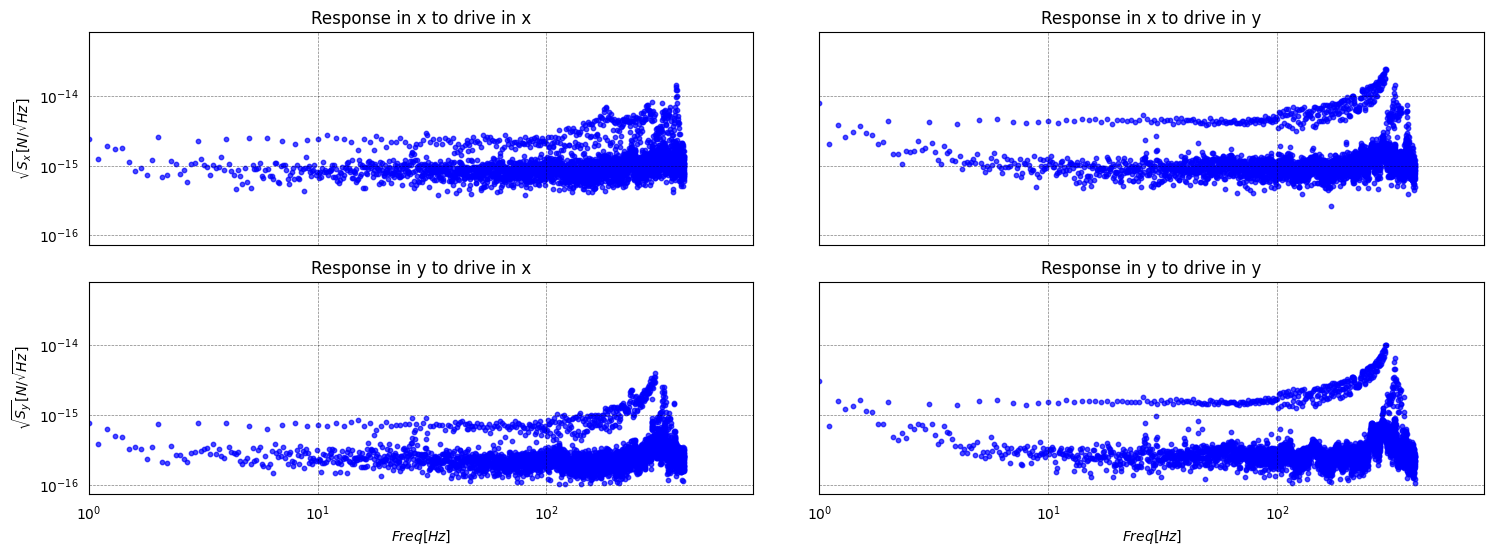

In [56]:
mca.makeTransferFuncPlot(subset_masks_reshaped_small, xtransf_camera_filepath, ytransf_camera_filepath, normscale=subset_force,
                                                color='blue', s=10, marker='o', label='From phases', alpha=0.7)

In [57]:
sums = mca.parallelSumsMasked_h5(subset_masks_reshaped_small, gravity_camera_filepath)
resx_subset = mca.windowed_psd(np.array(sums)[:,0]*subset_force[0], mca.getsamplingrate(gravity_camera_filepath))
resy_subset = mca.windowed_psd(np.array(sums)[:,1]*subset_force[1], mca.getsamplingrate(gravity_camera_filepath))
del sums

Starting ForkPoolWorker-109Starting
 ForkPoolWorker-110Starting
 ForkPoolWorker-111
Starting ForkPoolWorker-112Starting
 ForkPoolWorker-113
Starting ForkPoolWorker-114


(1e-16, 4e-15)

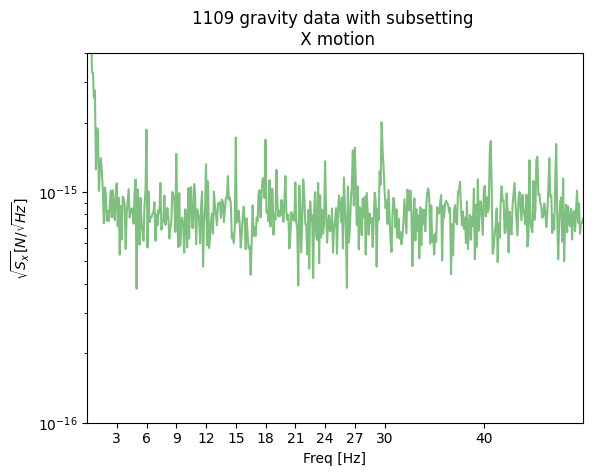

In [58]:
plt.semilogy(resx_subset[1],resx_subset[0], alpha=0.5, label = "Phase", color='green')
plt.xlim([0,50])
plt.ylabel(r'$\sqrt{S_x} [N/\sqrt{Hz}]$')
plt.xlabel("Freq [Hz]")
plt.xticks(np.append(np.arange(3,32,3),40))
plt.title("1109 gravity data with subsetting \n X motion")
plt.ylim(1e-16,4e-15)

(1e-16, 4e-15)

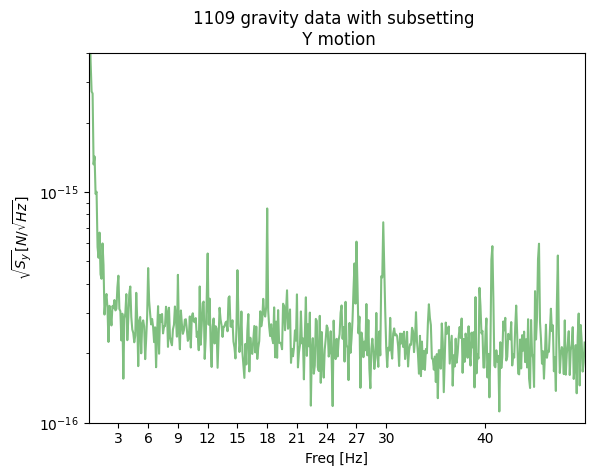

In [59]:
plt.semilogy(resy_subset[1],resy_subset[0], alpha=0.5, label = "Phase", color='green')
plt.xlim([0,50])
plt.ylabel(r'$\sqrt{S_y} [N/\sqrt{Hz}]$')
plt.xlabel("Freq [Hz]")
plt.xticks(np.append(np.arange(3,32,3),40))
plt.title("1109 gravity data with subsetting \n Y motion")
plt.ylim(1e-16,4e-15)